In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Lambda
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import sys

print("TensorFlow:", tf.__version__)
print("Python:", sys.version)
print("OpenCV:", cv2.__version__)

plt.rcParams['font.size'] = 18

TensorFlow: 2.7.0
Python: 3.7.12 (default, Jan 15 2022, 18:48:18) 
[GCC 7.5.0]
OpenCV: 4.1.2


shape : ((rcp or lcp), (real, image), width, height)

In [2]:
class InputToCx(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(InputToCx, self).__init__()
        self.output_dim = output_dim

    def call(self, inputs, **kwargs):
        rcp_real = inputs * tf.cos(0.0)
        rcp_imag = inputs * tf.sin(0.0)
        rcp = (1.0 / 2.0) * tf.stack([rcp_real, rcp_imag], axis=1)

        lcp_real = inputs * tf.cos(0.0)
        lcp_imag = inputs * tf.sin(0.0)
        lcp = (1.0 / 2.0) * tf.stack([lcp_real, lcp_imag], axis=1)
        return tf.stack([rcp, lcp], axis=1)

In [3]:
class CxMO(tf.keras.layers.Layer):
    def __init__(self, output_dim):
        super(CxMO, self).__init__()
        self.output_dim = output_dim

    # input[0,:,:] = real
    # input[1,:,:] = image
    def build(self, input_dim):
        self.phi = self.add_variable("phi",
                                     shape=[int(input_dim[-2]),
                                            int(input_dim[-1])])

        super(CxMO, self).build(input_dim)

    def call(self, x):
        x_rcp_real = Lambda(lambda x: x[:, 0, 0, :, :], output_shape=self.output_dim)(x)  # rcp real
        x_rcp_imag = Lambda(lambda x: x[:, 0, 1, :, :], output_shape=self.output_dim)(x)  # rcp image

        x_lcp_real = Lambda(lambda x: x[:, 1, 0, :, :], output_shape=self.output_dim)(x)  # lcp real
        x_lcp_imag = Lambda(lambda x: x[:, 1, 1, :, :], output_shape=self.output_dim)(x)  # lcp image

        mo_real = tf.cos(self.phi)
        mo_imag = tf.sin(self.phi)

        rcp_real = x_rcp_real * mo_real - x_rcp_imag * mo_imag
        rcp_imag = x_rcp_real * mo_imag + x_rcp_imag * mo_real

        lcp_real = x_lcp_real * mo_real - x_lcp_imag * mo_imag
        lcp_imag = x_lcp_real * mo_imag + x_lcp_imag * mo_real

        rcp = tf.stack([rcp_real, rcp_imag], axis=1)
        lcp = tf.stack([lcp_real, lcp_imag], axis=1)

        cmpx = tf.stack([rcp, lcp], axis=1)
        return cmpx

In [4]:
class FreeSpacePropagation(tf.keras.layers.Layer):
    def __init__(self, output_dim, k, z, input_pitch=1e-6, output_pitch=1e-6, normalization=None):
        super(FreeSpacePropagation, self).__init__()
        self.output_dim = output_dim
        self.input_pitch = input_pitch
        self.output_pitch = output_pitch
        self.z = z
        self.k = k
        self.normalization = normalization

    def build(self, input_shape):
        x1 = np.arange(0, input_shape[-1], 1)
        y1 = np.arange(0, input_shape[-2], 1)
        xx1, yy1 = np.meshgrid(x1, y1)
        xx1 = xx1.reshape(-1, 1) - input_shape[-1] / 2
        yy1 = yy1.reshape(-1, 1) - input_shape[-2] / 2

        x2 = np.arange(0, self.output_dim[1], 1)
        y2 = np.arange(0, self.output_dim[0], 1)
        xx2, yy2 = np.meshgrid(x2, y2)
        xx2 = xx2.reshape(1, -1) - self.output_dim[1] / 2
        yy2 = yy2.reshape(1, -1) - self.output_dim[0] / 2

        dx = (self.output_pitch * xx2 - self.input_pitch * xx1)
        dy = (self.output_pitch * yy2 - self.input_pitch * yy1)
        r = np.sqrt(dx ** 2 + dy ** 2 + self.z ** 2)
        w = 1 / (2 * np.pi) * self.z / r * (1 / r - 1j * self.k) * np.exp(1j * self.k * r)

        self.w_real = tf.Variable(initial_value=w.real.astype('float32'),
                                  trainable=False)
        self.w_imag = tf.Variable(initial_value=w.imag.astype('float32'),
                                  trainable=False)

        super(FreeSpacePropagation, self).build(input_shape)

    def call(self, x, **kwargs):
        x_rcp_real = Lambda(lambda x: x[:, 0, 0, :, :], output_shape=(self.output_dim,))(x)
        x_rcp_imag = Lambda(lambda x: x[:, 0, 1, :, :], output_shape=(self.output_dim,))(x)
        x_lcp_real = Lambda(lambda x: x[:, 1, 0, :, :], output_shape=(self.output_dim,))(x)
        x_lcp_imag = Lambda(lambda x: x[:, 1, 1, :, :], output_shape=(self.output_dim,))(x)

        x_rcp_real = tf.reshape(x_rcp_real, (-1, x.shape[-1] * x.shape[-2]))
        x_rcp_imag = tf.reshape(x_rcp_imag, (-1, x.shape[-1] * x.shape[-2]))
        x_lcp_real = tf.reshape(x_lcp_real, (-1, x.shape[-1] * x.shape[-2]))
        x_lcp_imag = tf.reshape(x_lcp_imag, (-1, x.shape[-1] * x.shape[-2]))

        rcp_real = tf.matmul(x_rcp_real, self.w_real) - tf.matmul(x_rcp_imag, self.w_imag)
        rcp_imag = tf.matmul(x_rcp_imag, self.w_real) - tf.matmul(x_rcp_real, self.w_imag)
        lcp_real = tf.matmul(x_lcp_real, self.w_real) - tf.matmul(x_lcp_imag, self.w_imag)
        lcp_imag = tf.matmul(x_lcp_imag, self.w_real) - tf.matmul(x_lcp_real, self.w_imag)

        rcp_real = tf.reshape(rcp_real, (-1, self.output_dim[0], self.output_dim[1]))
        rcp_imag = tf.reshape(rcp_imag, (-1, self.output_dim[0], self.output_dim[1]))
        lcp_real = tf.reshape(lcp_real, (-1, self.output_dim[0], self.output_dim[1]))
        lcp_imag = tf.reshape(lcp_imag, (-1, self.output_dim[0], self.output_dim[1]))

        rcp = tf.stack([rcp_real, rcp_imag], axis=1)
        lcp = tf.stack([lcp_real, lcp_imag], axis=1)

        cmpx = tf.stack([rcp, lcp], axis=1)

        if self.normalization == 'max':
            absmax = tf.reduce_max(tf.abs(cmpx))
            cmpx = cmpx / absmax

        return cmpx


In [5]:
class CxD2NNIntensity(tf.keras.layers.Layer):
    def __init__(self, output_dim, normalization='min_max', **kwargs):
        super(CxD2NNIntensity, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.normalization = normalization

    def call(self, x, **kwargs):
        x_rcp_real = Lambda(lambda x: x[:,0, 0, :, :])(x)
        x_rcp_imag = Lambda(lambda x: x[:,0, 1, :, :])(x)
        x_lcp_real = Lambda(lambda x: x[:,1, 0, :, :])(x)
        x_lcp_imag = Lambda(lambda x: x[:,1, 1, :, :])(x)
        i_rcp = tf.sqrt(x_rcp_real ** 2 + x_rcp_imag ** 2)
        i_lcp = tf.sqrt(x_lcp_real ** 2 + x_lcp_imag ** 2)
        intensity = (i_rcp + i_lcp) / 2
        if self.normalization == 'min_max':
            max = tf.reduce_max(intensity)
            min = tf.reduce_min(intensity)
            intensity = (intensity - min) / (max - min)
        if self.normalization == 'max':
            max = tf.reduce_max(intensity)
            intensity = intensity / max

        return intensity

In [6]:
class CxD2NNEllipticity(tf.keras.layers.Layer):
    def __init__(self, output_dim, **kwargs):
        super(CxD2NNEllipticity, self).__init__(**kwargs)
        self.output_dim = output_dim

    def call(self, x, **kwargs):
        x_rcp_real = Lambda(lambda x: x[:,0, 0, :, :])(x)
        x_rcp_imag = Lambda(lambda x: x[:,0, 1, :, :])(x)
        x_lcp_real = Lambda(lambda x: x[:,1, 0, :, :])(x)
        x_lcp_imag = Lambda(lambda x: x[:,1, 1, :, :])(x)
        i_rcp = tf.sqrt(x_rcp_real ** 2 + x_rcp_imag ** 2)
        i_lcp = tf.sqrt(x_lcp_real ** 2 + x_lcp_imag ** 2)
        ellipticity = (i_rcp - i_lcp)/(i_rcp + i_lcp)

        return ellipticity

In [7]:
class CxD2NNMNISTDetector(tf.keras.layers.Layer):
    def __init__(self, output_dim, activation=None, **kwargs):
        super(CxD2NNMNISTDetector, self).__init__(**kwargs)
        self.output_dim = output_dim
        self.activation = activation

    def build(self, input_shape):
        self.input_dim = input_shape
        self.width = min(int(tf.floor(self.input_dim[2] / 9.0)), int(tf.floor(self.input_dim[1] / 7.0)))
        self.height = min(int(tf.floor(self.input_dim[2] / 9.0)), int(tf.floor(self.input_dim[1] / 7.0)))
        super(CxD2NNMNISTDetector, self).build(input_shape)

    def plot_area(self, input_shape, same_color=False):
        width = min(int(np.floor(input_shape[1] / 9.0)), int(np.floor(input_shape[0] / 7.0)))
        height = min(int(np.floor(input_shape[1] / 9.0)), int(np.floor(input_shape[0] / 7.0)))
        x = np.zeros(input_shape)
        if same_color:
            x[2 * height:3 * height, width:2 * width] = 1
            x[2 * height:3 * height, 4 * width:5 * width] = 1
            x[2 * height:3 * height, 7 * width:8 * width] = 1
            x[4 * height:5 * height, 1 * width:2 * width] = 1
            x[4 * height:5 * height, 3 * width:4 * width] = 1
            x[4 * height:5 * height, 5 * width:6 * width] = 1
            x[4 * height:5 * height, 7 * width:8 * width] = 1
            x[6 * height:7 * height, width:2 * width] = 1
            x[6 * height:7 * height, 4 * width:5 * width] = 1
            x[6 * height:7 * height, 7 * width:8 * width] = 1
        else:
            x[2 * height:3 * height, width:2 * width] = 1
            x[2 * height:3 * height, 4 * width:5 * width] = 2
            x[2 * height:3 * height, 7 * width:8 * width] = 3
            x[4 * height:5 * height, 1 * width:2 * width] = 4
            x[4 * height:5 * height, 3 * width:4 * width] = 5
            x[4 * height:5 * height, 5 * width:6 * width] = 6
            x[4 * height:5 * height, 7 * width:8 * width] = 7
            x[6 * height:7 * height, width:2 * width] = 8
            x[6 * height:7 * height, 4 * width:5 * width] = 9
            x[6 * height:7 * height, 7 * width:8 * width] = 10
        plt.imshow(x)

    def call(self, x, **kwargs):
        y0 = x[:, 2 * self.height:3 * self.height, self.width:2 * self.width]
        y1 = x[:, 2 * self.height:3 * self.height, 4 * self.width:5 * self.width]
        y2 = x[:, 2 * self.height:3 * self.height, 7 * self.width:8 * self.width]
        y3 = x[:, 4 * self.height:5 * self.height, self.width:2 * self.width]
        y4 = x[:, 4 * self.height:5 * self.height, 3 * self.width:4 * self.width]
        y5 = x[:, 4 * self.height:5 * self.height, 5 * self.width:6 * self.width]
        y6 = x[:, 4 * self.height:5 * self.height, 7 * self.width:8 * self.width]
        y7 = x[:, 6 * self.height:7 * self.height, self.width:2 * self.width]
        y8 = x[:, 6 * self.height:7 * self.height, 4 * self.width:5 * self.width]
        y9 = x[:, 6 * self.height:7 * self.height, 7 * self.width:8 * self.width]
        y0 = tf.reduce_sum(y0, axis=[1])
        y0 = tf.reduce_sum(y0, axis=[1], keepdims=True)
        y1 = tf.reduce_sum(y1, axis=[1])
        y1 = tf.reduce_sum(y1, axis=[1], keepdims=True)
        y2 = tf.reduce_sum(y2, axis=[1])
        y2 = tf.reduce_sum(y2, axis=[1], keepdims=True)
        y3 = tf.reduce_sum(y3, axis=[1])
        y3 = tf.reduce_sum(y3, axis=[1], keepdims=True)
        y4 = tf.reduce_sum(y4, axis=[1])
        y4 = tf.reduce_sum(y4, axis=[1], keepdims=True)
        y5 = tf.reduce_sum(y5, axis=[1])
        y5 = tf.reduce_sum(y5, axis=[1], keepdims=True)
        y6 = tf.reduce_sum(y6, axis=[1])
        y6 = tf.reduce_sum(y6, axis=[1], keepdims=True)
        y7 = tf.reduce_sum(y7, axis=[1])
        y7 = tf.reduce_sum(y7, axis=[1], keepdims=True)
        y8 = tf.reduce_sum(y8, axis=[1])
        y8 = tf.reduce_sum(y8, axis=[1], keepdims=True)
        y9 = tf.reduce_sum(y9, axis=[1])
        y9 = tf.reduce_sum(y9, axis=[1], keepdims=True)
        y = tf.keras.layers.concatenate([y0, y1, y2, y3, y4, y5, y6, y7, y8, y9])

        if self.activation == 'softmax':
            y = tf.nn.softmax(y)
        return y

In [8]:
def create_true_mnistimage(label, shape):
    width = min(int(np.floor(shape[1] / 9.0)), int(np.floor(shape[0] / 7.0)))
    height = min(int(np.floor(shape[1] / 9.0)), int(np.floor(shape[0] / 7.0)))
    x = np.zeros(shape)

    if label == 0:
        x[2 * height:3 * height, width:2 * width] = 1.0
    elif label == 1:
        x[2 * height:3 * height, 4 * width:5 * width] = 1.0
    elif label == 2:
        x[2 * height:3 * height, 7 * width:8 * width] = 1.0
    elif label == 3:
        x[4 * height:5 * height, 1 * width:2 * width] = 1.0
    elif label == 4:
        x[4 * height:5 * height, 3 * width:4 * width] = 1.0
    elif label == 5:
        x[4 * height:5 * height, 5 * width:6 * width] = 1.0
    elif label == 6:
        x[4 * height:5 * height, 7 * width:8 * width] = 1.0
    elif label == 7:
        x[6 * height:7 * height, width:2 * width] = 1.0
    elif label == 8:
        x[6 * height:7 * height, 4 * width:5 * width] = 1.0
    elif label == 9:
        x[6 * height:7 * height, 7 * width:8 * width] = 1.0

    return x

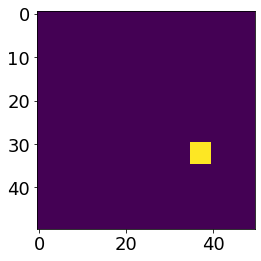

In [ ]:
plt.imshow(create_true_mnistimage(9, (50, 50)))

In [9]:
mnist = tf.keras.datasets.mnist

image_shape = (28, 28)
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.array(list(map(lambda image: cv2.resize(image, dsize=image_shape), x_train)))
x_test = np.array(list(map(lambda image: cv2.resize(image, dsize=image_shape), x_test)))
y_train_image = np.array(list(map(lambda y_label: create_true_mnistimage(y_label, image_shape), y_train)))
y_test_image = np.array(list(map(lambda y_label: create_true_mnistimage(y_label, image_shape), y_test)))
x_train = x_train / 255.0
x_test = x_test / 255.0

11501568/11490434 [==============================] - 0s 0us/step


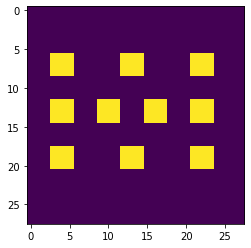

In [10]:
detector = CxD2NNMNISTDetector(10)
detector.plot_area((28, 28), same_color=True)

In [11]:
def loss(y_hat, y):
    return tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_hat, logits=y)


def loss_MSE(y_hat, y):
    return tf.reduce_sum((y_hat - y) ** 2)

In [12]:
l = 633e-9
k = 2 * np.pi / l
d = 1e-6


In [ ]:
inputs = keras.Input(image_shape)
x = InputToCx(image_shape)(inputs)
x = CxMO(image_shape)(x)
x = FreeSpacePropagation(image_shape, k, 1.0e-4, normalization='max', input_pitch=2.0e-6, output_pitch=2.0e-6)(x)
x = CxD2NNIntensity(image_shape, normalization='max')(x)
x = CxD2NNMNISTDetector(10, activation='softmax')(x)
model = tf.keras.Model(inputs, x)
model.summary()
model.compile(optimizer='adam',
              loss="sparse_categorical_crossentropy",  # category: sparse_categorical_crossentropy
              metrics=['accuracy'])

epochs = 10
early_stopping = EarlyStopping(
    monitor='accuracy',
    min_delta=0.05,
    patience=2,
)

result = model.fit(x_train,
                   y_train,
                   batch_size=64,
                   epochs=epochs
                   #callbacks=[early_stopping]
                   )
model.save("28x28_6(MO_frspc100um)")

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28)]          0         
_________________________________________________________________
input_to_cx_1 (InputToCx)    (None, 2, 2, 28, 28)      0         
_________________________________________________________________
cx_mo_1 (CxMO)               (None, 2, 2, 28, 28)      784       
_________________________________________________________________
free_space_propagation_1 (Fr (None, 2, 2, 28, 28)      1229312   
_________________________________________________________________
cx_d2nn_intensity (CxD2NNInt (None, 28, 28)            0         
_________________________________________________________________
cx_d2nnmnist_detector_1 (CxD (None, 10)                0         
Total params: 1,230,096
Trainable params: 784
Non-trainable params: 1,229,312
_______________________________________________

KeyboardInterrupt: 

In [ ]:
fig = plt.figure(figsize=(6, 6))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.plot(range(1, epochs + 1), result.history['loss'], color='black', label='Loss')
ax1.set_ylabel('Loss')
ax1.set_xlabel('epoch')
ax2.plot(range(1, epochs + 1), result.history['accuracy'], color='red', label='Accuracy')
ax2.set_ylabel('Accuracy')
# label1と2には、凡例用に各labelのリスト情報が入る
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
# 凡例をまとめて出力する
ax1.legend(handler1 + handler2, label1 + label2, loc=2, borderaxespad=0.)

In [ ]:
model.evaluate(x_test, y_test)

In [ ]:
layer_name = model.layers[-2].name
hidden_layer_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
hidden_layer_model.summary()

In [ ]:
num = 5
images = x_train[0:num, :, :]

preds = model.predict(images)
pred_images = hidden_layer_model.predict(images)
fig, axes = plt.subplots(num, 3, figsize=(7, 10))
for i in range(num):
    axes[i, 0].imshow(images[i, :, :])
    axes[i, 1].imshow(pred_images[i, :, :])
    axes[i, 2].bar(np.arange(0, 10, 1), preds[i, :], align='center')
    axes[i, 2].set_xticks(np.arange(0, 10, 1))
    axes[i, 2].set_ylabel('Accuracy')
fig.tight_layout()

In [ ]:
layer_outputs = [layer.output for layer in model.layers[1:]]
layer_outputs

In [ ]:
activation_model = keras.Model(inputs=model.input, outputs=layer_outputs)
activation_model.summary()

In [ ]:
num = 5
images = x_train[0:num, :, :]
activations = activation_model.predict(images)
len(activations)

In [ ]:
fig, axes = plt.subplots(num, len(activations) - 2, figsize=(2 * len(activations) - 1, 2 * num))
for i in range(len(activations) - 2):
    layer_activation = activations[i]
    for j in range(num):
        intensity = tf.sqrt(layer_activation[j, 0, :, :] ** 2 + layer_activation[j, 1, :, :] ** 2)
        axes[j, i].imshow(intensity)

In [19]:
train_num = 10
test_num = 10
total = train_num + test_num
train_data = {}
test_data = {}
for i in range(10):
  train_data[str(i)] = x_train[np.where(y_train[:1000] == i)][0:train_num]
  test_data[str(i)] = x_test[np.where(y_test[:1000] == i)][0:test_num]

In [13]:
inputs = keras.Input((28, 28))
x = InputToCx((28, 28))(inputs)
x = FreeSpacePropagation((28, 28), k, 1.0e-4)(x)
x = CxD2NNIntensity((28, 28))(x)

model = tf.keras.Model(inputs, x)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28)]          0         
                                                                 
 input_to_cx (InputToCx)     (None, 2, 2, 28, 28)      0         
                                                                 
 free_space_propagation (Fre  (None, 2, 2, 28, 28)     1229312   
 eSpacePropagation)                                              
                                                                 
 cx_d2nn_intensity (CxD2NNIn  (None, 28, 28)           0         
 tensity)                                                        
                                                                 
Total params: 1,229,312
Trainable params: 0
Non-trainable params: 1,229,312
_________________________________________________________________


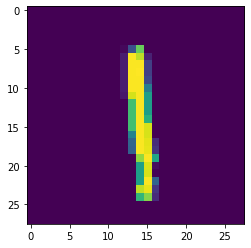

In [25]:
plt.imshow(train_data["1"][2, :, :])

In [26]:
pred = model.predict((train_data["5"]))
pred.shape

(10, 28, 28)

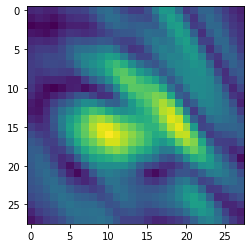

In [29]:
plt.imshow(pred[4,:,:])